## Loading the Classification model and Data

---



In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!cp '/content/gdrive/MyDrive/ML Project/archive.zip' /content/
!cp '/content/gdrive/MyDrive/ML Project/10_epochs_transfer_10_epochs_finetune.h5' /content/

In [3]:
!cd /content/
!unzip archive.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/JULIA/042.jpg     
  inflating: train/JULIA/043.jpg     
  inflating: train/JULIA/044.jpg     
  inflating: train/JULIA/045.jpg     
  inflating: train/JULIA/046.jpg     
  inflating: train/JULIA/047.jpg     
  inflating: train/JULIA/048.jpg     
  inflating: train/JULIA/049.jpg     
  inflating: train/JULIA/050.jpg     
  inflating: train/JULIA/051.jpg     
  inflating: train/JULIA/052.jpg     
  inflating: train/JULIA/053.jpg     
  inflating: train/JULIA/054.jpg     
  inflating: train/JULIA/055.jpg     
  inflating: train/JULIA/056.jpg     
  inflating: train/JULIA/057.jpg     
  inflating: train/JULIA/058.jpg     
  inflating: train/JULIA/059.jpg     
  inflating: train/JULIA/060.jpg     
  inflating: train/JULIA/061.jpg     
  inflating: train/JULIA/062.jpg     
  inflating: train/JULIA/063.jpg     
  inflating: train/JULIA/064.jpg     
  inflating: train/JULIA/065.jpg     
  inflating: train/JULIA/066.jpg     

In [4]:
import numpy as np
import pandas as pd
import os
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory

In [5]:
model = tf.keras.models.load_model('/content/10_epochs_transfer_10_epochs_finetune.h5')

In [6]:
test_ds = image_dataset_from_directory('/content/test', shuffle=False)
IMG_SIZE = 240
size = (IMG_SIZE, IMG_SIZE)
test_ds = test_ds.map(lambda image, label:
                      (tf.image.resize(image, size), label))

Found 375 files belonging to 75 classes.


## Generating Embedding

---



In [7]:
x_test = np.concatenate(
    [batch for batch, label in test_ds.as_numpy_iterator()])
near_neighbours_per_example = 4
embeddings = model.predict(x_test,batch_size=5)
print(embeddings.shape)
gram_matrix = np.einsum("ae,be->ab", embeddings, embeddings)
near_neighbours = np.argsort(gram_matrix.T)[:, -(near_neighbours_per_example + 1) :]

(375, 75)


## Collage

---



In [8]:
import random
import matplotlib.pyplot as plt
from collections import defaultdict
from PIL import Image
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow import keras
from tensorflow.keras import layers

In [9]:
height_width = 32
def show_collage(examples):
    box_size = height_width + 2
    num_rows, num_cols = examples.shape[:2]

    collage = Image.new(
        mode="RGB",
        size=(num_cols * box_size, num_rows * box_size),
        color=(250, 250, 250),
    )
    for row_idx in range(num_rows):
        for col_idx in range(num_cols):
            array = (np.array(examples[row_idx, col_idx])).astype(np.uint8)
            collage.paste(
                Image.fromarray(array), (col_idx * box_size, row_idx * box_size)
            )

    # Double size for visualisation.
    collage = collage.resize((2 * num_cols * box_size, 2 * num_rows * box_size))
    return collage


In [10]:
size = (height_width, height_width)
test_ds = test_ds.map(lambda image, label:
                      (tf.image.resize(image, size), label))
x_test = np.concatenate(
    [batch for batch, label in test_ds.as_numpy_iterator()])
y_test = np.concatenate(
    [label for batch, label in test_ds.as_numpy_iterator()])
class_idx_to_test_idxs = defaultdict(list)
for y_test_idx, y in enumerate(y_test):
    class_idx_to_test_idxs[y].append(y_test_idx)

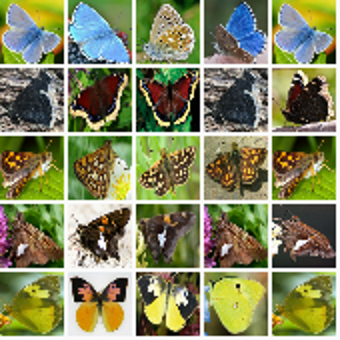

In [ ]:
num_collage_examples = 5

examples = np.empty(
    (
        num_collage_examples,
        near_neighbours_per_example + 1,
        height_width,
        height_width,
        3,
    ),
    dtype=np.float32,
)
for row_idx in range(num_collage_examples):
    temp_idx=random.randint(0, len(y_test)-1)
    examples[row_idx, 0] = x_test[temp_idx]
    anchor_near_neighbours = reversed(near_neighbours[temp_idx][:-1])
    for col_idx, nn_idx in enumerate(anchor_near_neighbours):
        examples[row_idx, col_idx + 1] = x_test[nn_idx]

show_collage(examples)

## Evaluation

---



In [11]:
train_ds = image_dataset_from_directory('/content/train')
class_names = train_ds.class_names
class_count = len(class_names)
print(class_names)

Found 9285 files belonging to 75 classes.
['ADONIS', 'AFRICAN GIANT SWALLOWTAIL', 'AMERICAN SNOOT', 'AN 88', 'APPOLLO', 'ATALA', 'BANDED ORANGE HELICONIAN', 'BANDED PEACOCK', 'BECKERS WHITE', 'BLACK HAIRSTREAK', 'BLUE MORPHO', 'BLUE SPOTTED CROW', 'BROWN SIPROETA', 'CABBAGE WHITE', 'CAIRNS BIRDWING', 'CHECQUERED SKIPPER', 'CHESTNUT', 'CLEOPATRA', 'CLODIUS PARNASSIAN', 'CLOUDED SULPHUR', 'COMMON BANDED AWL', 'COMMON WOOD-NYMPH', 'COPPER TAIL', 'CRECENT', 'CRIMSON PATCH', 'DANAID EGGFLY', 'EASTERN COMA', 'EASTERN DAPPLE WHITE', 'EASTERN PINE ELFIN', 'ELBOWED PIERROT', 'GOLD BANDED', 'GREAT EGGFLY', 'GREAT JAY', 'GREEN CELLED CATTLEHEART', 'GREY HAIRSTREAK', 'INDRA SWALLOW', 'IPHICLUS SISTER', 'JULIA', 'LARGE MARBLE', 'MALACHITE', 'MANGROVE SKIPPER', 'MESTRA', 'METALMARK', 'MILBERTS TORTOISESHELL', 'MONARCH', 'MOURNING CLOAK', 'ORANGE OAKLEAF', 'ORANGE TIP', 'ORCHARD SWALLOW', 'PAINTED LADY', 'PAPER KITE', 'PEACOCK', 'PINE WHITE', 'PIPEVINE SWALLOW', 'POPINJAY', 'PURPLE HAIRSTREAK', 'PURP

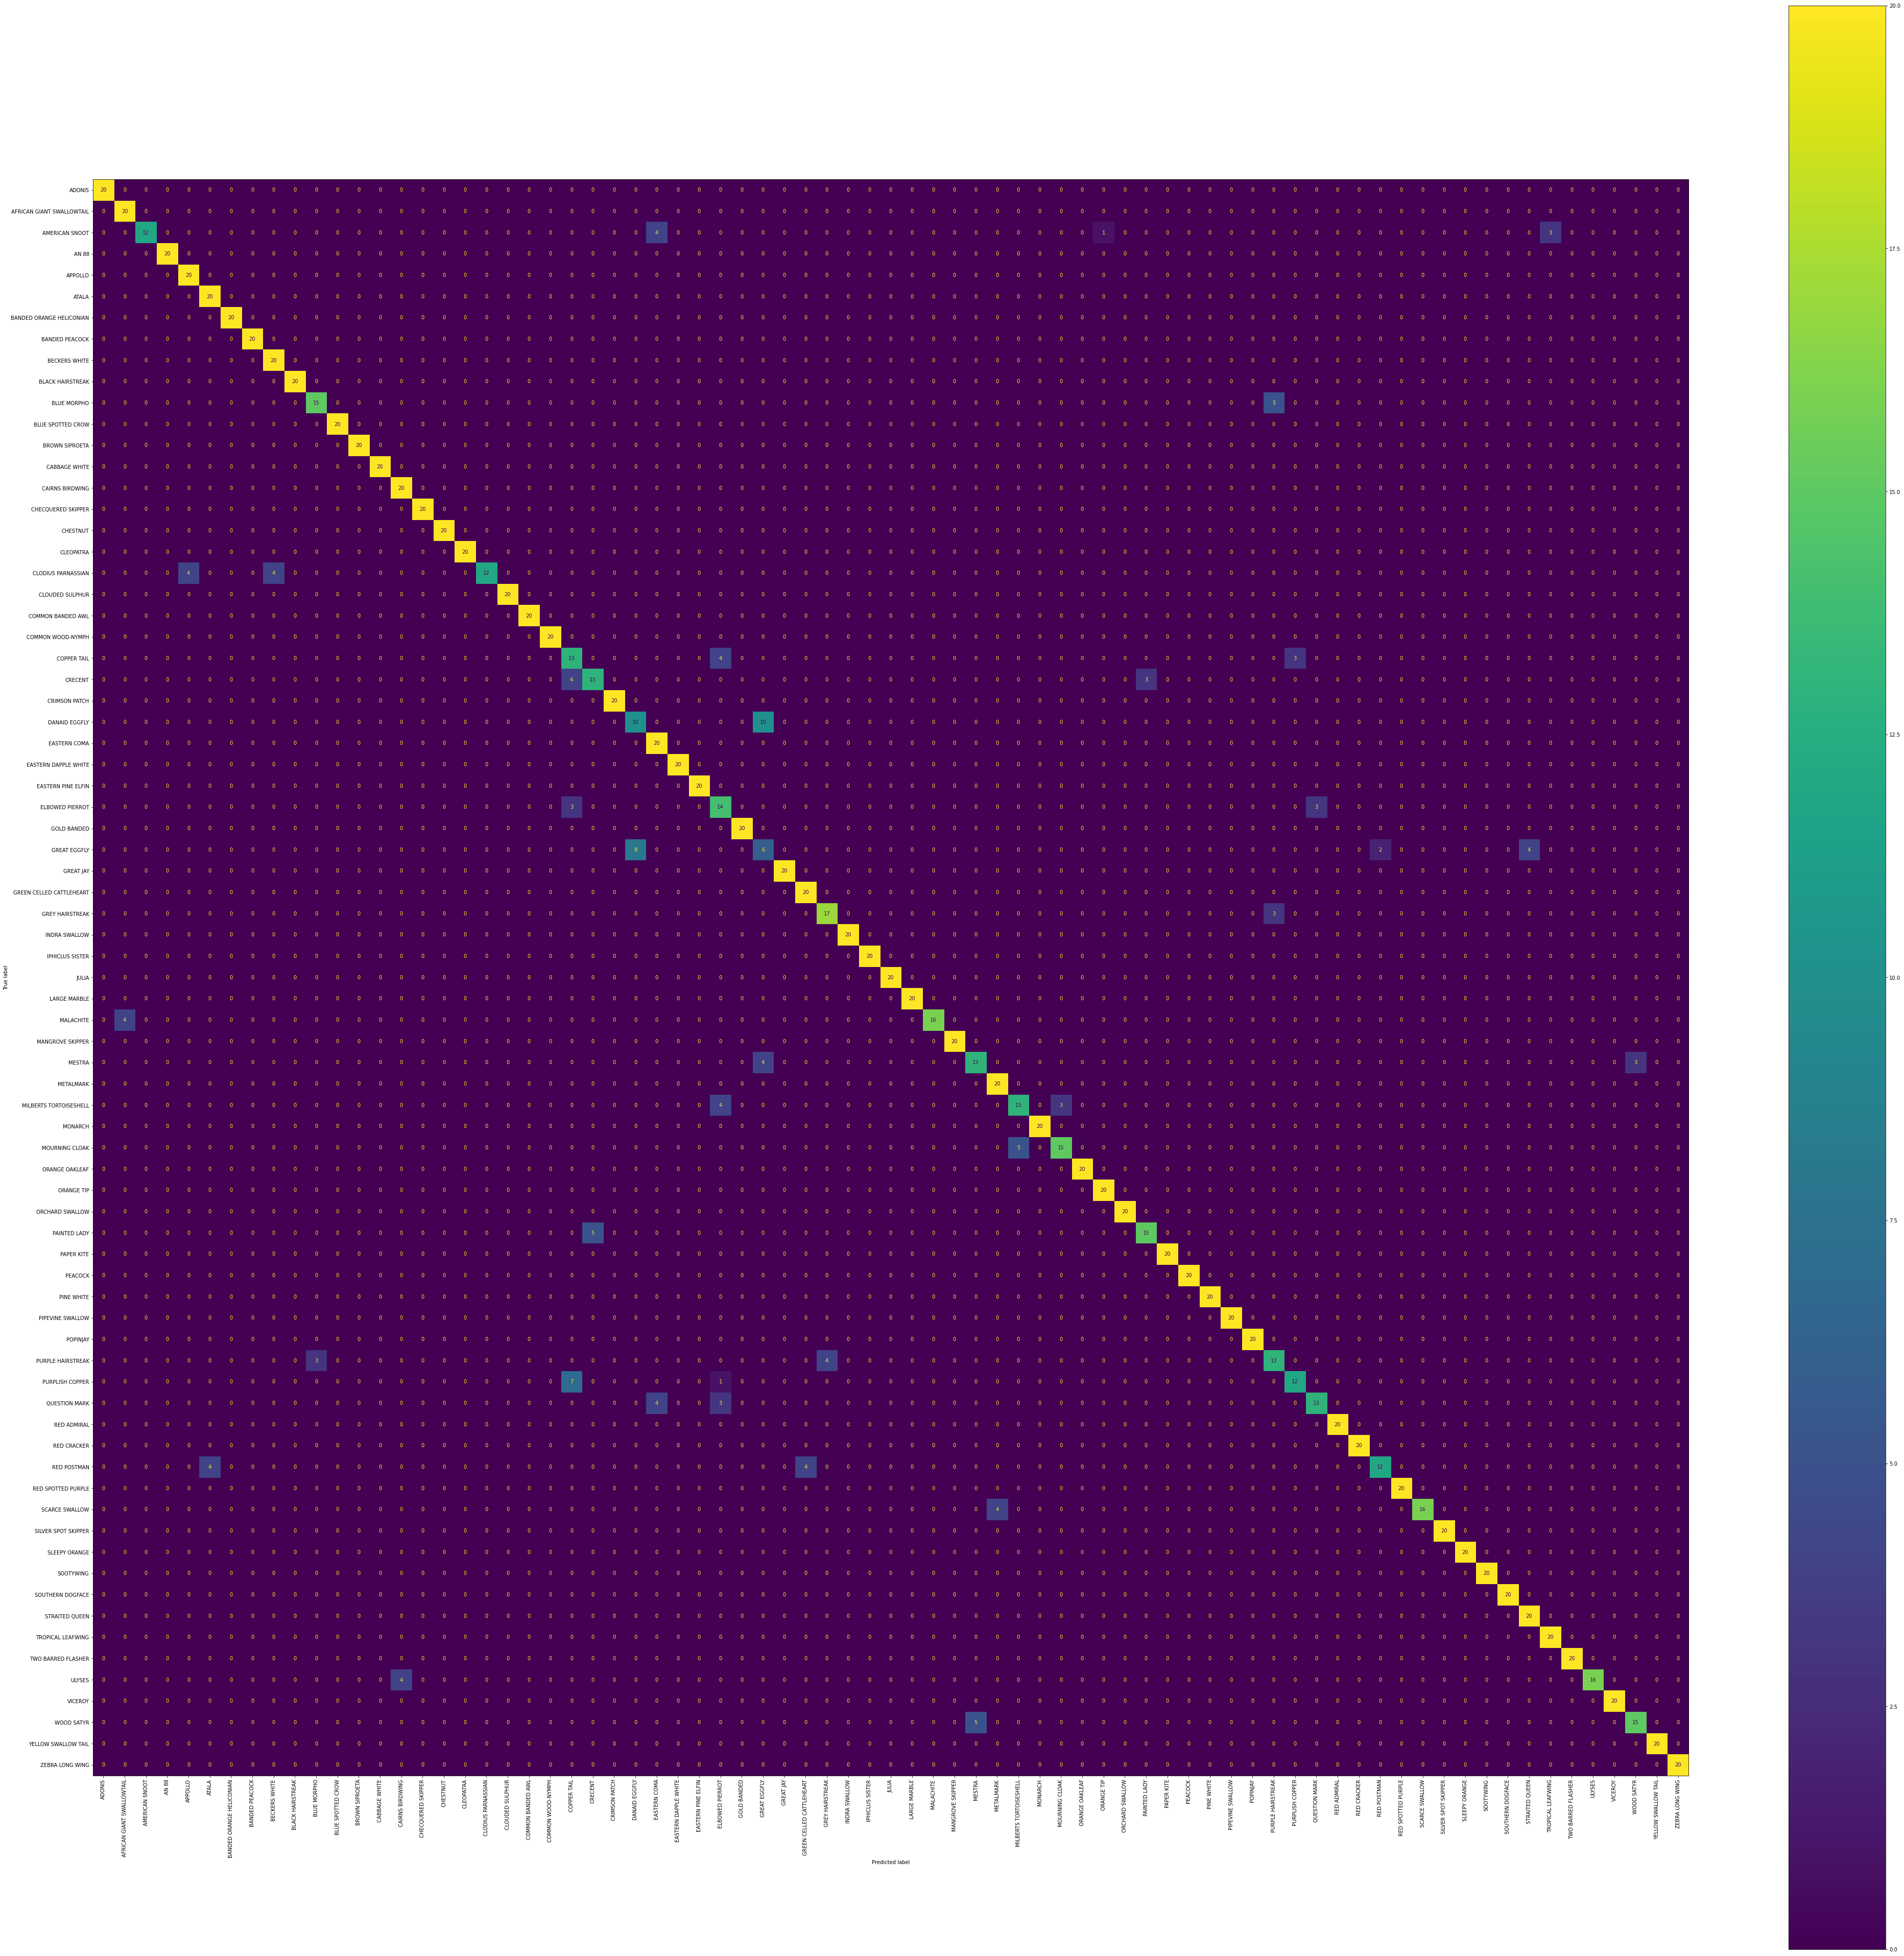

In [14]:
confusion_matrix = np.zeros((class_count, class_count), dtype=int)

# For each class.
for class_idx in range(class_count):
    # Consider 10 examples.
    example_idxs = class_idx_to_test_idxs[class_idx][:10]
    for y_test_idx in example_idxs:
        # And count the classes of its near neighbours.
        for nn_idx in near_neighbours[y_test_idx][:-1]:
            nn_class_idx = y_test[nn_idx]
            confusion_matrix[class_idx, nn_class_idx] += 1

# Display a confusion matrix.
labels = class_names
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=labels)
fig, ax = plt.subplots(figsize=(70,70))
disp.plot(include_values=True, cmap="viridis", ax=ax, xticks_rotation="vertical")
plt.show()


In [16]:
y_true = []
y_pred = []
for class_idx in range(class_count):
    for neighbour_class_idx in range(class_count):
        cnt_recommend = confusion_matrix[class_idx][neighbour_class_idx]
        y_true += cnt_recommend * [class_idx]
        y_pred += cnt_recommend * [neighbour_class_idx]

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       0.83      1.00      0.91        20
           2       1.00      0.60      0.75        20
           3       1.00      1.00      1.00        20
           4       0.83      1.00      0.91        20
           5       0.83      1.00      0.91        20
           6       1.00      1.00      1.00        20
           7       1.00      1.00      1.00        20
           8       0.83      1.00      0.91        20
           9       1.00      1.00      1.00        20
          10       0.83      0.75      0.79        20
          11       1.00      1.00      1.00        20
          12       1.00      1.00      1.00        20
          13       1.00      1.00      1.00        20
          14       0.83      1.00      0.91        20
          15       1.00      1.00      1.00        20
          16       1.00      1.00      1.00        20
          17       1.00    